In [4]:
import json
import numpy as np
from textblob import TextBlob

userdict={}
with open('./yelp/user.json') as user_file:
    for line in user_file:
        d=json.loads(line)
        if (d["review_count"]>150):
            userdict[d["user_id"]] = d["review_count"] 

In [5]:
count={}
with open('./yelp/review.json') as review_file:
    for line in review_file:
        d=json.loads(line)        
        if (d["user_id"] in count):
            count[d["user_id"]]+=1
        else:
            count[d["user_id"]]=1

userlist=[]
for key in count:
    if (count[key]>100):
        userlist.append(key)
print len(userlist)

1238


In [6]:
businessdict = {}
with open('./yelp/business.json') as business_file:
    for line in business_file:
        d=json.loads(line)
        businessdict[d["business_id"]] = d["stars"]

In [9]:
master_review={}
with open('./yelp/review.json') as review_file:
    for line in review_file:
        d=json.loads(line)
        if (d["user_id"] in userlist):
            if (d["user_id"] not in master_review):
                master_review[d["user_id"]] = {}
            
            key=int(d["date"].replace("-","")+"00")
            while (key in master_review[d["user_id"]]):
                key+=1
            
            ls = [d["business_id"], d["stars"], d["text"]]
            master_review[d["user_id"]][key]=ls

In [34]:
import random
diff_n_stars=[]
diff_pred=[]
actual_pred=[]
ba_pred=[]
rates=[]
avg_diff=[]

diff_sentiments=[]
for uid in userlist:
    #uid = userlist[4]
    reviewdict=master_review[uid]
    dates = sorted(reviewdict, key=reviewdict.get)
    n_stars=[]
    overall_stars=[]
    n_sentiments=[]
    for i in range(30):
        n_stars.append(reviewdict[dates[i]][1])
        review_text = reviewdict[dates[i]][2]
        blob = TextBlob(review_text)
        n_sentiments.append(blob.sentiment.polarity)
        
    for d in dates:
        overall_stars.append(reviewdict[d][1])
        
    diff_n_stars.append(abs(np.mean(n_stars)-np.mean(overall_stars)))
    
    #normalize sentiments
    
    diff_sentiments.append((np.mean(n_sentiments)+1)/2.0-(np.mean(n_stars)-1)/5.0)
    
    
    # choose random 30 dates
    dates2 = dates[30:]
    random.shuffle(dates2)
    dates2 = dates2[:30]

    #get the sentiment of the current review and the rate
    actual_stars=[]
    pred_sentiments=[]
    business_stars=[]
    for date in dates2:
        business_stars.append(businessdict[reviewdict[date][0]])
        actual_stars.append(reviewdict[date][1])
        pred_text = reviewdict[date][2]
        blob = TextBlob(pred_text)
        pred_sentiments.append(blob.sentiment.polarity)
    
    
    #calculate the predicted rating based on users average sentiment
    pred_stars=[]
    avg_stars=np.mean(n_stars)
    avg_sentiments = np.mean(n_sentiments)
    # absolute differnece between predicted ratings and the actual ratings
    diff1=[]
    for i in range(30):
        pred=(pred_sentiments[i]-avg_sentiments)/2*5+avg_stars
        pred=min(5, pred)
        pred=max(1, pred)
        pred_stars.append(pred)
        diff1.append(abs(pred-actual_stars[i]))
        diff_pred.append(abs(pred-actual_stars[i]))
    avg_diff.append(np.mean(diff1))
    
    count=0
    for i in range(30):
        actual_pred.append(actual_stars[i]-pred_stars[i])
        ba_pred.append(business_stars[i]-pred_stars[i])
        if (business_stars[i]-pred_stars[i])*(actual_stars[i]-pred_stars[i])>0:
            count+=1 
        
    rates.append(count/30.0)


print np.mean(diff_n_stars)
print np.mean(diff_pred)
print np.mean(rates) 

0.13875283688
0.756666406997
0.627894453419


(array([ 206.,  186.,  191.,  159.,  119.,  105.,   83.,   64.,   38.,
          25.,   21.,   17.,    4.,    7.,    2.,    4.,    4.,    2.,
           0.,    1.]),
 array([ 0.        ,  0.03536232,  0.07072464,  0.10608696,  0.14144928,
         0.17681159,  0.21217391,  0.24753623,  0.28289855,  0.31826087,
         0.35362319,  0.38898551,  0.42434783,  0.45971014,  0.49507246,
         0.53043478,  0.5657971 ,  0.60115942,  0.63652174,  0.67188406,
         0.70724638]),
 <a list of 20 Patch objects>)

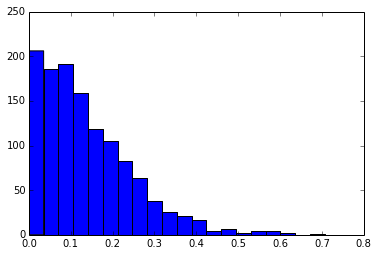

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(diff_n_stars, bins=20)


(array([   1.,    7.,   11.,   22.,   40.,   96.,  133.,  166.,  190.,
         190.,  138.,  120.,   50.,   41.,   14.,   10.,    3.,    3.,
           2.,    1.]),
 array([-0.14495593, -0.12135186, -0.09774779, -0.07414372, -0.05053965,
        -0.02693558, -0.00333151,  0.02027256,  0.04387663,  0.0674807 ,
         0.09108477,  0.11468884,  0.13829291,  0.16189698,  0.18550105,
         0.20910512,  0.23270919,  0.25631326,  0.27991733,  0.3035214 ,
         0.32712547]),
 <a list of 20 Patch objects>)

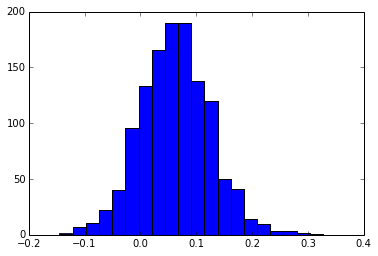

In [32]:
plt.hist(diff_sentiments, bins=20)

(array([  6.44000000e+03,   6.00400000e+03,   5.30000000e+03,
          4.53800000e+03,   3.78500000e+03,   3.31800000e+03,
          2.54400000e+03,   1.88400000e+03,   1.22100000e+03,
          7.54000000e+02,   4.96000000e+02,   3.55000000e+02,
          2.28000000e+02,   1.34000000e+02,   7.60000000e+01,
          3.20000000e+01,   1.40000000e+01,   9.00000000e+00,
          5.00000000e+00,   3.00000000e+00]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ]),
 <a list of 20 Patch objects>)

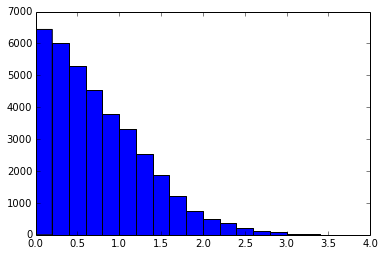

In [17]:
plt.hist(diff_pred, bins=20)

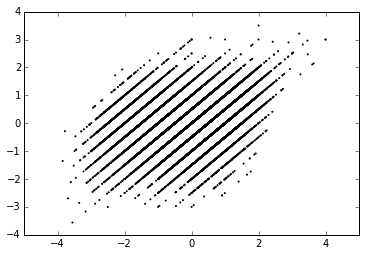

In [27]:
plt.scatter(actual_pred, ba_pred, s=1)


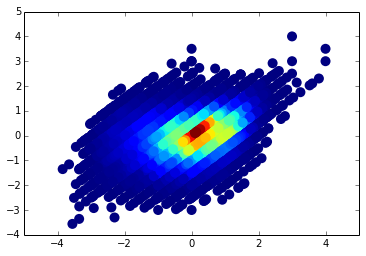

In [33]:
from scipy.stats import gaussian_kde
xy=np.vstack([actual_pred, ba_pred])
z=gaussian_kde(xy)(xy)
plt.scatter(actual_pred, ba_pred, c=z, s=100, edgecolor='')


In [35]:
print len(avg_diff)

1238


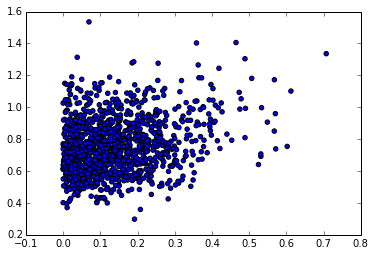

In [36]:
plt.scatter(diff_n_stars, avg_diff)

In [37]:
np.corrcoef(diff_n_stars, avg_diff)

array([[ 1.        ,  0.24974843],
       [ 0.24974843,  1.        ]])